## 3. Análisis de emociones en *tweets*

El análisis de emociones o sentimientos se refiere al proceso de extraer información acerca de la actitud que una persona (o grupo de ellas) manifiesta, en un determinado medio o formato digital, con respecto a un tópico o contexto de comunicación. Uno de los casos más estudiados corresponde a determinar la polaridad de un trozo de texto, es decir, clasificar una determinada evaluación escrita (review ), en que una persona manifiesta una opinión, como positiva, negativa o neutral. Esto también ha sido extendido a otros medios, como lo es analizar la polaridad de textos en redes sociales.

<img src="https://image.flaticon.com/sprites/new_packs/132222-color-emotions-assets.png" width="40%" />



Para esta actividad se trabajará con un datasets de tweets ofrecidos por CrowdFlower[[8]](#refs). Cada *tweet* está
asociado a una emoción en particular, donde el conjunto de emociones se trabajarán como mutuamente excluyentes, siendo un problema de múltiples clases.

Los datos pueden ser descargados ejecutando el siguiente código en sistema Unix:
```
wget https://www.crowdflower.com/wp-content/uploads/2016/07/text_emotion.csv
```

Para aumentar la eficacia de las caracterı́sticas extraı́das es conveniente ejecutar algunas técnicas de pre-procesamiento básicas.

> a) Construya un dataframe con los datos a analizar. Determine cuántas clases existen, cuántos registros por clase y describa el dataset.

In [1]:
import pandas as pd
df = pd.read_csv('text_emotion.csv')

df.shape
df.info('label')
df.groupby('sentiment')['sentiment'].count()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 4 columns):
tweet_id     40000 non-null int64
sentiment    40000 non-null object
author       40000 non-null object
content      40000 non-null object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


sentiment
anger          110
boredom        179
empty          827
enthusiasm     759
fun           1776
happiness     5209
hate          1323
love          3842
neutral       8638
relief        1526
sadness       5165
surprise      2187
worry         8459
Name: sentiment, dtype: int64

In [2]:
df.dtypes

tweet_id      int64
sentiment    object
author       object
content      object
dtype: object

Abstract

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text xticklabel objects>)

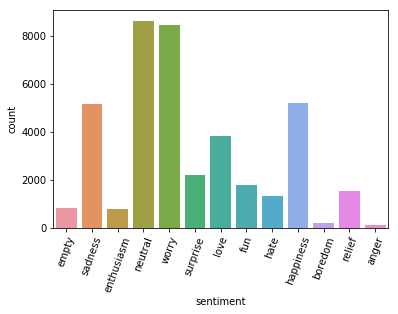

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.countplot(x= "sentiment",data=df)
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['axes.labelsize'] = 20
plt.xticks(rotation=70)


> b) Construya un conjunto de entrenamiento y otro de pruebas, a través de una máscara aleatoria, para verificar los resultados de los algoritmos. Genere un conjunto de validación si estima conveniente.

In [30]:
import numpy as np
#a = np.seed(70)

df_test_star = df[df["sentiment"]=='empty'] #este df es espacial, al menos para mi hacer pruebas si alguno se parece 
df_clean= df.drop(['tweet_id', 'author' ],axis=1).values
df_clean_x = df.drop(['tweet_id', 'author', 'sentiment' ],axis=1).values
df_clean_y = df.drop(['tweet_id', 'author', 'content' ],axis=1).values
msk = np.random.rand(len(df)) < 0.8
#rows = [line.split(" ",1) for line in df.readlines()]
#df_train = pd.DataFrame(rows, columns=['sentiment','content'])
#df_train['Sentiment'] = pd.to_numeric(df_train['sentiment'])
df_train = df_clean[msk]#respaldo de los datos de entrenamiento
x_train = df_clean_x[msk]#training data
y_val = df_clean_y[msk]#validation set for our training data
df_val = df_clean[~msk]#respaldo para los datis de validacion
x_test = df_clean_x[~msk]
y_test = df_clean_y[~msk]
df_train.shape
print(df_train)


[['empty'
  '@tiffanylue i know  i was listenin to bad habit earlier and i started freakin at his part =[']
 ['sadness'
  'Layin n bed with a headache  ughhhh...waitin on your call...']
 ['enthusiasm' 'wants to hang out with friends SOON!']
 ...
 ['neutral' '@JohnLloydTaylor']
 ['love' 'Happy Mothers Day  All my love']
 ['happiness'
  '@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!!  PEEP OUT MY NEW HIT SINGLES WWW.MYSPACE.COM/IPSOHOT I DEF. WAT U IN THE VIDEO!!']]


In [5]:
print(msk)
print(~msk)

[ True False  True ...  True  True  True]
[False  True False ... False False False]


c) Construya las representaciones de los datos con los que trabajará, ya sea para las entradas de los modelos como para las salidas. Recuerde que tendrá que codificar las distintas clases como valores numéricos enteros.

In [31]:
y_val[y_val== 'empty'] = 0
y_val[y_val== 'sadness'] = 1
y_val[y_val== 'enthusiasm'] = 2
y_val[y_val== 'neutral'] = 3
y_val[y_val== 'worry'] = 4
y_val[y_val== 'surprise'] = 5
y_val[y_val== 'love'] = 6
y_val[y_val== 'fun'] = 7
y_val[y_val== 'hate'] = 8
y_val[y_val== 'happiness'] = 9
y_val[y_val== 'boredom'] = 10
y_val[y_val== 'relief'] = 11
y_val[y_val== 'anger'] = 12
print(y_train[7][0])
#classes  = pd.get_dummies(df, columns=["sentiment"]) #column to categorical
#classes = nuevo_df.drop(['tweet_id', 'author','content' ],axis=1)
#classes.head(6)



4


In [32]:
import re, time
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer, word_tokenize
from nltk.stem.porter import PorterStemmer
def word_extractor1(text):
    wordlemmatizer = WordNetLemmatizer()
    commonwords = stopwords.words('english')
    text = re.sub(r'([a-z])\1+', r'\1\1',text)#substitute multiple letter by two
    words = ""
    wordtokens = [ wordlemmatizer.lemmatize(word.lower())for word in word_tokenize(text.decode('utf-8', 'ignore')) ]
    for word in wordtokens:
        if word not in commonwords:
            words+=" "+word
    return words

In [34]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
texts_train1 = [word_extractor1(text) for text in x_train]

vectorizer1 = CountVectorizer(ngram_range=(1, 1), binary='False')
vectorizer1.fit(np.asarray(texts_train1))


TypeError: cannot use a string pattern on a bytes-like object

> d) Entrene y compare al menos 4 de los diferentes clasificadores vistos en clases para clasificación (por ejemplo: Navie Bayes, Multinomial Naive Bayes, LDA, QDA, Regresión logı́stica y Perceptrón). Recuerde que algunos son extendidos por defecto a múltiples clases para detectar emociones en cada *tweet*, sin embargo, otros deben ser extentidos a través de otras técnicas, tal como *One vs One* y *One vs All/Rest*. Muestre tabla o gráfico resumen.


In [28]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.naive_bayes import MultinomialNB
#example
clf = MultinomialNB()
classif = OneVsOneClassifier(clf)
################
#classif1 = OneVsRestClassifier(df_train)
classif.fit(x_train,y_train)
######
print("Accuracy under training: ",classif.score(x,y))

#or for LR
LogisticRegression(multi_class= 'ovr' or 'multinomial')

ValueError: could not convert string to float: '@mopedronin bullet train from tokyo    the gf and i have been visiting japan since thursday  vacation/sightseeing    gaijin godzilla'

> e) Utilice la técnica de ECOC (*Error-Correcting Output-Code*) para extender a multiclases algunos de los clasificadores utilizados en d). Comente lo que hace la técnica y los resultados observados.

> f) Evalúe la métrica de *accuracy* sobre el conjunto de pruebas del mejor clasificador encontrado.  
*Recuerde que puede acudir a otras métricas para tener otras visiones de lo que está haciendo el modelo de aprendizaje*

> g) Intente mejorar su resultado considerablemente a través de alguna mejora novedosa. Se espera que supere el 35% de *accuracy*.

In [8]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True